**Instruction for POS Tagging Using RNNs with Arabic Dataset**

**Dataset:**
The dataset provided is named "Assignment 2 - Arabic POS.conllu". It contains labeled data for Arabic text with Part-of-Speech (POS) tags in CoNLL-U format.

**Objective:**
Your objective is to perform Part-of-Speech (POS) tagging on Arabic text using Recurrent Neural Networks (RNNs). Specifically, you will use the Universal POS (UPOS) tags for tagging. UPOS is a standardized set of POS tags that aims to cover all languages.

**Evaluation metric:**
Accuracy

**Instructions:**
1. **Data Preprocessing:**
   - Load the provided dataset "Assignment 2 - Arabic POS.conllu". You can use pyconll library
   - Preprocess the data as necessary, including tokenization

2. **Model Building:**
   - Design an RNN-based model architecture suitable for POS tagging. You may consider using recurrent layers such as (LSTM) or (GRU).
   - Define the input and output layers of the model. The input layer should accept sequences of tokens, and the output layer should produce the predicted UPOS tags for each token.

3. **Training:**

4. **Evaluation:**

**Additional Notes:**
- Make sure to document your code thoroughly and provide clear explanations for each step.
- Feel free to explore different RNN architectures, hyperparameters, and optimization techniques to improve the model's accuracy.

### Import used libraries

In [628]:
pip install pyconll

In [629]:
pip install contractions

In [630]:
import pyconll
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer
import string
import contractions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from sklearn import metrics
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [631]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Dataset

In [632]:
corpus = pyconll.load_from_file("Assignment 2 - Arabic POS.conllu")

In [633]:
# Initialize empty lists to store data
data = {'SentenceID': [], 'ID': [], 'FORM': [],'UPOS': []}

In [634]:
for sentence_id, sentence in enumerate(corpus, start=1):
        for token in sentence:
            # Append token attributes to the respective lists
            data['SentenceID'].append(sentence_id)
            data['ID'].append(token.id)
            data['FORM'].append(token.form)
            data['UPOS'].append(token.upos)

In [635]:
df = pd.DataFrame(data)
df.head(10)

,SentenceID,ID,FORM,UPOS
0,1,1,برلين,X
1,1,2,ترفض,VERB
2,1,3,حصول,NOUN
3,1,4,شركة,NOUN
4,1,5,اميركية,ADJ
5,1,6,على,ADP
6,1,7,رخصة,NOUN
7,1,8,تصنيع,NOUN
8,1,9,دبابة,NOUN
9,1,10,"""",PUNCT


In [636]:
df.columns

Index(['SentenceID', 'ID', 'FORM', 'UPOS'], dtype='object')

In [637]:
df = df[['SentenceID','FORM','UPOS']]

In [638]:
df.head(10)

,SentenceID,FORM,UPOS
0,1,برلين,X
1,1,ترفض,VERB
2,1,حصول,NOUN
3,1,شركة,NOUN
4,1,اميركية,ADJ
5,1,على,ADP
6,1,رخصة,NOUN
7,1,تصنيع,NOUN
8,1,دبابة,NOUN
9,1,"""",PUNCT


### Data splitting

In [639]:
x = df.drop(['UPOS'],axis=1)

In [640]:
y = df['UPOS']

In [641]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.15)

In [642]:
x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

- Cleaning and Preprocessing are:
    - 1) Remove duplicated
    - 2) Remove diacritics
    - 3) Stop Words
    - 4) Stemmer
    - 5) Tokenizer


## Cleaning and Preprocessing(train data)





In [643]:
y_train.value_counts()

UPOS
NOUN     57050
ADP      25639
ADJ      17949
PUNCT    13387
VERB     12869
CCONJ    12183
X        10566
PRON      6540
NUM       4578
DET       3580
SCONJ     3374
AUX       1320
PART      1283
ADV        667
SYM        258
PROPN      140
INTJ         5
Name: count, dtype: int64

In [644]:
#check null values
x_train.isnull().sum()

SentenceID    0
FORM          0
dtype: int64

In [645]:
#check duplicated
x_train['FORM'].duplicated().sum()

165538

In [646]:
# Check for duplicated forms in the training data
duplicates_mask = x_train['FORM'].duplicated()

# Find the duplicated rows
duplicate_rows = x_train[duplicates_mask]

In [647]:
duplicate_rows

,SentenceID,FORM
248875,5912,س
221385,5094,و
253180,6042,قال
209513,4764,و
213134,4851,ان
...,...,...
155068,3571,ميزانية
58748,1649,الاتهامات
107689,2471,و
139247,3165,ها


### Remove duplicated values





In [648]:
# Remove duplicate rows from x_train and y_train
x_train = x_train[~duplicates_mask].copy()
y_train = y_train[~duplicates_mask].copy()

In [649]:
x_train.shape, len(y_train)

((29078, 2), 29078)

In [650]:
x_train['FORM'].duplicated().sum()

0

In [651]:
x_train.head(10)

,SentenceID,FORM
171254,3922,ها
218197,4996,الامريكية
200836,4597,تجاه
148938,3405,ثالثة
98916,2328,الظرف
27482,731,ذلك
151430,3463,4
23290,615,رغم
13152,342,قال
26732,710,س


In [652]:
# regular expression for Arabic diacritics
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                            ـ    | # Tatwil/Kashida
                         """, re.VERBOSE)

In [653]:
# Lambda function to remove diacritics from text
remove_diacritics = lambda text: arabic_diacritics.sub('', text)

In [654]:
x_train['FORM'] = x_train['FORM'].apply(remove_diacritics)

In [655]:
x_train.head(20)

,SentenceID,FORM
171254,3922,ها
218197,4996,الامريكية
200836,4597,تجاه
148938,3405,ثالثة
98916,2328,الظرف
27482,731,ذلك
151430,3463,4
23290,615,رغم
13152,342,قال
26732,710,س


In [656]:
# Load Arabic stop words
stop_words = stopwords.words('arabic')


In [657]:
# Initialize Arabic stemmer
stemmer = ISRIStemmer()

In [658]:
# Function to preprocess tokens
def preprocess_token(token):
    # Remove stop words
    if token in stop_words:
        return None

    # Stem the token
    token = stemmer.stem(token)

    return token

In [659]:
# Apply preprocessing to 'Token' column
x_train['FORM'] = x_train['FORM'].apply(preprocess_token)

In [660]:
# Find rows with null values in the 'FORM' column
null_token_rows = x_train[x_train['FORM'].isna()].index

# Drop these rows from the DataFrame
x_train = x_train.drop(null_token_rows)
y_train = y_train.drop(null_token_rows)

In [661]:
x_train.isnull().sum()

SentenceID    0
FORM          0
dtype: int64

In [662]:
x_train.shape, len(y_train)

((28722, 2), 28722)

In [663]:
x_train.head(20)

,SentenceID,FORM
218197,4996,امر
148938,3405,ثلث
98916,2328,ظرف
151430,3463,4
23290,615,رغم
13152,342,قال
16344,425,ان
179837,4119,عرب
125300,2851,أشر
11562,305,(


## Cleaning and Preprocessing(validation data)

In [664]:
x_val['FORM'] = x_val['FORM'].apply(remove_diacritics)

In [665]:
# Apply preprocessing to 'Token' column
x_val['FORM'] = x_val['FORM'].apply(preprocess_token)

In [666]:
# Find rows with null values in the 'FORM' column
null_token_rows = x_val[x_val['FORM'].isna()].index

# Drop these rows from the DataFrame
x_val = x_val.drop(null_token_rows)
y_val = y_val.drop(null_token_rows)

In [667]:
x_val.isnull().sum()

SentenceID    0
FORM          0
dtype: int64

In [668]:
x_val.shape, len(y_val)

((15597, 2), 15597)

## Cleaning and Preprocessing(test data)

In [669]:
x_test['FORM'] = x_test['FORM'].apply(remove_diacritics)

In [670]:
# Apply preprocessing to 'Token' column
x_test['FORM'] = x_test['FORM'].apply(preprocess_token)

In [671]:
# Find rows with null values in the 'FORM' column
null_token_rows = x_test[x_test['FORM'].isna()].index

# Drop these rows from the DataFrame
x_test = x_test.drop(null_token_rows)
y_test = y_test.drop(null_token_rows)

In [672]:
x_test.isnull().sum()

SentenceID    0
FORM          0
dtype: int64

In [673]:
x_test.shape, len(y_test)

((27543, 2), 27543)

###Tokenizer

In [674]:
x_all = pd.concat([x_train, x_val, x_test])

# Concatenate y_train, y_val, and y_test
y_all = pd.concat([y_train, y_val, y_test])

# Reset indices to ensure they are continuous
x_all.reset_index(drop=True, inplace=True)
y_all.reset_index(drop=True, inplace=True)

# Merge x_all and y_all on index
df = pd.concat([x_all, y_all], axis=1)

# Display the first few rows of the combined dataframe
print(df.head())

   SentenceID FORM  UPOS
0        4996  امر   ADJ
1        3405  ثلث   ADJ
2        2328  ظرف  NOUN
3        3463    4   NUM
4         615  رغم   ADP


In [675]:
# Sort the DataFrame by 'SentenceID'
df_new = df.sort_values(by='SentenceID')

# Reset the index
df_new.reset_index(drop=True, inplace=True)

# Display the first few rows of the sorted dataframe
print(df_new.head())

   SentenceID FORM   UPOS
0           1    "  PUNCT
1           1  رخص   NOUN
2           1  لمن    ADJ
3           1  رفض   VERB
4           2  صنع   NOUN


In [676]:
df_new['SentenceID'].unique()

array([   1,    2,    3, ..., 6073, 6074, 6075])

In [677]:
words = list(set(df_new['FORM'].values))
words.append("ENDPAD")
num_words = len(words)
num_words

8134

In [678]:
tags = list(set(df_new['UPOS'].values))
num_tags = len(tags)
num_tags

18

In [679]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p) for w, p in zip(s["FORM"].values.tolist(),
                                                           s["UPOS"].values.tolist())]
        self.grouped = self.data.groupby("SentenceID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [680]:
getter = SentenceGetter(df_new)
sentences = getter.sentences

In [681]:
sentences[0]

[('"', 'PUNCT'), ('رخص', 'NOUN'), ('لمن', 'ADJ'), ('رفض', 'VERB')]

In [682]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

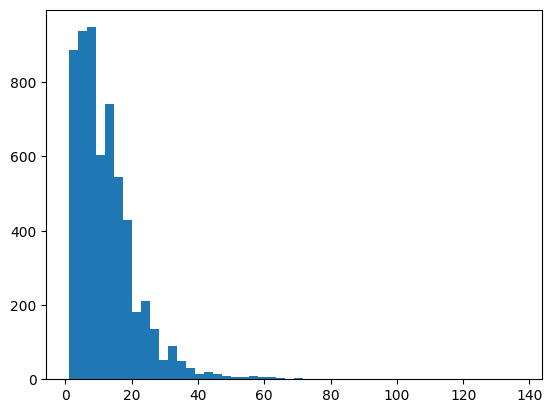

In [683]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [684]:
max_sequence_len = max(len(seq) for seq in sentences)
print("Maximum sequence length :", max_sequence_len)

Maximum sequence length : 137


In [685]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_sequence_len, sequences=X, padding="post")

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_sequence_len, sequences=y, padding="post")

### Modelling

In [686]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [688]:
input_word = Input(shape=(max_sequence_len,))
model = Embedding(input_dim=num_words, output_dim=60, input_length=max_sequence_len)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 137)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 137, 60)           488040    
                                                                 
 bidirectional_10 (Bidirect  (None, 137, 200)          128800    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 137, 200)          240800    
 ional)                                                          
                                                                 
 time_distributed_5 (TimeDi  (None, 137, 18)           3618      
 stributed)                                                      
                                                           

In [689]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [693]:
tf.config.run_functions_eagerly(True)

In [694]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    verbose=1,
    validation_split=0.1
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


134/134 [==============================] - 1139s 8s/step - loss: 0.3074 - accuracy: 0.9328 - val_loss: 0.1662 - val_accuracy: 0.9404
Epoch 2/5
134/134 [==============================] - 1098s 8s/step - loss: 0.1656 - accuracy: 0.9411 - val_loss: 0.1624 - val_accuracy: 0.9415
Epoch 3/5
134/134 [==============================] - 1090s 8s/step - loss: 0.1622 - accuracy: 0.9419 - val_loss: 0.1606 - val_accuracy: 0.9426
Epoch 4/5
134/134 [==============================] - 1048s 8s/step - loss: 0.1597 - accuracy: 0.9423 - val_loss: 0.1589 - val_accuracy: 0.9428
Epoch 5/5
134/134 [==============================] - 1082s 8s/step - loss: 0.1549 - accuracy: 0.9430 - val_loss: 0.1484 - val_accuracy: 0.9453


#### Evaluation

**Evaluation metric:**
Accuracy

In [695]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Convert accuracy to percentage
accuracy_percentage = accuracy * 100

print("Accuracy on test set: {:.2f}%".format(accuracy_percentage))

Accuracy on test set: 94.33%


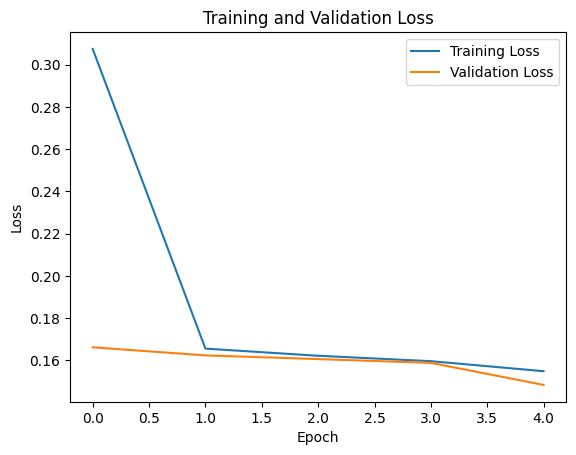

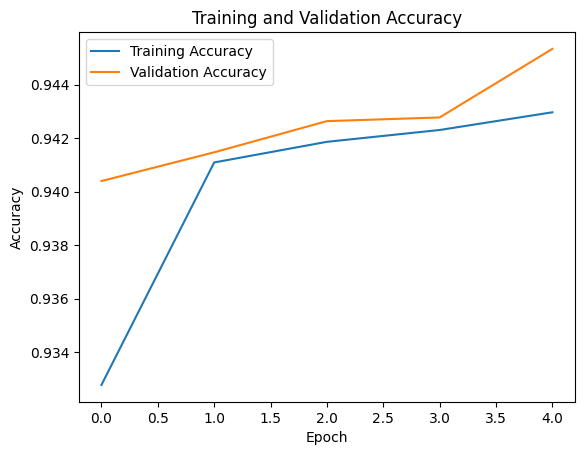

In [696]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Done!